# Model Improvments

- this was dont in google colab for GPU/TPU Usage

## Imports

In [19]:
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import PReLU
from keras.initializers import Constant
from tensorflow.keras.layers import BatchNormalization

tensorflow.random.set_seed(42)



## Google Connect

In [20]:
# from google.colab import drive
# drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Unzip data

In [ ]:
from zipfile import ZipFile
file_name = 'drive/MyDrive/datasets/data.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

In [ ]:
train_path = 'data/train_features_img/'
test_path = 'data/test_features_img'

## Helper Functions

In [83]:
def plot_metrics2(model_fit):
    metrics = ['accuracy', 'precision', 'recall']
    for i in metrics:
        plt.plot(model_fit.history[i], label='Train')
        plt.plot(model_fit.history[f'val_{i}'], label='Test')
        plt.ylabel(i)
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()

def plot_metrics1(model_fit, save_plots=False):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    titles = ['Loss Optimization', 'Categorical Accuracy Performance', 'Precision Performance', 'Recall Performance']
    for j, i in enumerate(metrics):
        plt.plot(model_fit.history[i], label='Train')
        plt.plot(model_fit.history[f'val_{i}'], label='Test')
        plt.ylabel(i)
        plt.xlabel('epochs')
        plt.title(titles[j])
        plt.legend()
        plt.show()
        if save_plots:
            plt.savefig(f'../images/{titles[j]}.png')

def find_specifset(low=0.4, high=0.4):
  ans = []
  for index, value, in (round(train.groupby(['site'])['animal_classification'].value_counts(normalize=True), 2)).iteritems():
    if value >= low and value <= high:
      ans.append([index, value])
  return ans
        
def merge_animals(df):
    """_summary_

    Args:
        df (_type_): _description_

    Returns:
        _type_: _description_
    """
    df_copy = df.copy() # copy df
    columns = df_copy.columns # get column names
    df_copy['animal_classification'] = np.where(df_copy.values)[1]+1 # add a numeric value to each column
    df_copy.drop(columns ,axis=1, inplace=True) # drop columns that were just combined
    return df_copy
#                ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
# Classification:           1           2        3           4          5        6              7               8

## Import/Format ImageGenerator Mapping Data

In [23]:
# drive/MyDrive/datasets/Kaggle_Comp/Africa/
test_features = pd.read_csv('data/test_features.csv')
train_features = pd.read_csv('data/train_features.csv')
train_labels = pd.read_csv('data/train_labels.csv')

In [24]:
train = pd.merge(left=train_features, right=train_labels, on='id') # combine df's and the right answer

In [25]:
# combine train df's on id
train = pd.merge(left=train_features, right=train_labels, on='id') 

# see function in above cell
train['animal_classification'] = merge_animals(train[['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']]) 
# done in function above ^ might need 
# train.drop(['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent'] ,axis=1, inplace=True) # drop

# rename numeric observations to actual classifications
train['animal_classification'] = train['animal_classification'].map({1:'antelope_duiker', 2:'bird', 3:'blank', 4:'civet_genet', 5:'hog', 6:'leopard', 7:'monkey_prosimian', 8:'rodent'})

# split file path column to get file names
temp = train['filepath'].str.split(pat='/',expand=True)
# rename split columns
temp.rename(columns={0: 'old_folder_location', 1: 'filename'}, inplace=True)

# concat columns and original df
train = pd.concat([train, temp], axis=1).drop(columns=['filepath'],axis=1)


## Final Model Iterations

### Attempt 1:

In [26]:
# train
img_gen = ImageDataGenerator(
        height_shift_range=0.07,
        horizontal_flip=True,
        preprocessing_function=tensorflow.image.rgb_to_grayscale,
        validation_split=.15
)
train_generator = img_gen.flow_from_dataframe(
    train,
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

validation_generator = img_gen.flow_from_dataframe(
    train,
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)


Found 14015 validated image filenames belonging to 8 classes.
Found 2473 validated image filenames belonging to 8 classes.


In [1]:
model3 = Sequential()
# input layers
model3.add(EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3)))
model3.add(PReLU(alpha_initializer=Constant(value=0.25)))
model3.add(GlobalAveragePooling2D())
model3.add(Flatten())
model3.add(Dropout(0.8))

# hidden layers
# 1
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.7))
# # 2
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.7))
# output layer
model3.add(Dense(units=8, activation='softmax'))

model3.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
callback = [EarlyStopping(monitor='val_loss', patience=20)]
history3 = model3.fit(
    train_generator,
    batch_size=32,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callback
)

### Attempt 2: Final

In [71]:
# train
img_gen = ImageDataGenerator(
        height_shift_range=0.07,
        horizontal_flip=True,
        preprocessing_function=tensorflow.image.rgb_to_grayscale,
        validation_split=.15
)
train_generator = img_gen.flow_from_dataframe(
    train,
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

validation_generator = img_gen.flow_from_dataframe(
    train,
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

model3 = Sequential()
# input layers
model3.add(EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3)))
model3.add(PReLU(alpha_initializer=Constant(value=0.25)))
model3.add(GlobalAveragePooling2D())
model3.add(Flatten())
model3.add(Dropout(0.8))

# hidden layers
# 1
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.7))
# # 2
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.7))
# output layer
model3.add(Dense(units=8, activation='softmax'))

model3.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
callback = [EarlyStopping(monitor='val_loss', patience=7)]
history3 = model3.fit(
    train_generator,
    batch_size=32,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callback
)

Found 14015 validated image filenames belonging to 8 classes.
Found 2473 validated image filenames belonging to 8 classes.
Epoch 1/50
438/438 [==============================] - 447s 997ms/step - loss: 1.9957 - accuracy: 0.2354 - recall: 0.0611 - precision: 0.5590 - val_loss: 1.6956 - val_accuracy: 0.3684 - val_recall: 0.1245 - val_precision: 0.8902
Epoch 2/50
438/438 [==============================] - 432s 986ms/step - loss: 1.6550 - accuracy: 0.3661 - recall: 0.1649 - precision: 0.7383 - val_loss: 1.4761 - val_accuracy: 0.4278 - val_recall: 0.1848 - val_precision: 0.7746
Epoch 3/50
438/438 [==============================] - 429s 980ms/step - loss: 1.5112 - accuracy: 0.4123 - recall: 0.1954 - precision: 0.7604 - val_loss: 1.3455 - val_accuracy: 0.4642 - val_recall: 0.2341 - val_precision: 0.8064
Epoch 4/50
438/438 [==============================] - 432s 985ms/step - loss: 1.3655 - accuracy: 0.4591 - recall: 0.2422 - precision: 0.7891 - val_loss: 1.2271 - val_accuracy: 0.5107 - val_reca

### Predictions:

In [73]:
# generating soft predictions (returns probabilities)
val_preds = model3.predict(validation_generator)
print(val_preds.shape)
val_preds

(2473, 8)


array([[5.7695033e-06, 3.8038577e-09, 8.2027661e-03, ..., 9.3435405e-14,
        2.6399546e-10, 9.9170977e-01],
       [9.1589338e-01, 6.6403713e-04, 4.6626829e-02, ..., 1.8242448e-05,
        3.1793915e-02, 1.2737839e-03],
       [9.9959069e-01, 2.6286393e-10, 4.6248791e-05, ..., 3.7398209e-14,
        3.6135284e-04, 5.2855365e-09],
       ...,
       [9.9859852e-01, 5.8446510e-08, 4.9129024e-04, ..., 1.5886013e-11,
        8.3184277e-04, 1.1096341e-05],
       [7.2746610e-07, 3.0181341e-10, 3.9150296e-03, ..., 6.8109517e-16,
        1.0499931e-11, 9.9606627e-01],
       [1.1654358e-01, 8.4793037e-03, 4.8243679e-02, ..., 7.7580655e-05,
        8.2658094e-01, 3.5447745e-05]], dtype=float32)

In [74]:
# converting to hard predictions
val_preds_class = np.array([np.where(array == array.max(), 1, 0) for array in val_preds]) #highest probability yields true for that class
print(val_preds_class.shape)
val_preds_class

(2473, 8)


array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [75]:
# flattening to 1D array for confusion matrix
val_preds_class_1D = np.array([np.argmax(row) for row in val_preds_class])
print(val_preds_class_1D.shape)
val_preds_class_1D

(2473,)


array([7, 0, 0, ..., 0, 7, 6])

### Evaluation:

In [76]:
# gathering true image labels to compare to predicted labels
val_labels = np.array(validation_generator.classes)
print(val_labels.shape)
val_labels

(2473,)


array([1, 6, 1, ..., 4, 0, 6])

In [77]:
# recall the label,index pairing
label_names = list(train_generator.class_indices.keys()) #will use for confusion matrix
train_generator.class_indices

{'antelope_duiker': 0,
 'bird': 1,
 'blank': 2,
 'civet_genet': 3,
 'hog': 4,
 'leopard': 5,
 'monkey_prosimian': 6,
 'rodent': 7}

In [78]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay

In [79]:
print(classification_report(val_labels, val_preds_class_1D, target_names=label_names))

                  precision    recall  f1-score   support

 antelope_duiker       0.14      0.12      0.13       366
            bird       0.09      0.10      0.09       255
           blank       0.10      0.08      0.09       330
     civet_genet       0.16      0.17      0.17       351
             hog       0.08      0.08      0.08       143
         leopard       0.15      0.16      0.15       337
monkey_prosimian       0.14      0.16      0.15       367
          rodent       0.11      0.12      0.11       324

        accuracy                           0.13      2473
       macro avg       0.12      0.12      0.12      2473
    weighted avg       0.13      0.13      0.13      2473



In [80]:
multi_confmatrix = {label_names[i]:matrix for i, matrix in enumerate(multilabel_confusion_matrix(val_labels, val_preds_class_1D))}
multi_confmatrix

{'antelope_duiker': array([[1832,  275],
        [ 321,   45]]), 'bird': array([[1965,  253],
        [ 230,   25]]), 'blank': array([[1911,  232],
        [ 304,   26]]), 'civet_genet': array([[1812,  310],
        [ 290,   61]]), 'hog': array([[2191,  139],
        [ 131,   12]]), 'leopard': array([[1838,  298],
        [ 284,   53]]), 'monkey_prosimian': array([[1766,  340],
        [ 310,   57]]), 'rodent': array([[1840,  309],
        [ 286,   38]])}

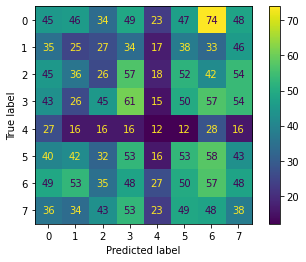

In [81]:
ConfusionMatrixDisplay.from_predictions(val_labels, val_preds_class_1D)
#plt.savefig('../images/multi_confusion_matrix.png')

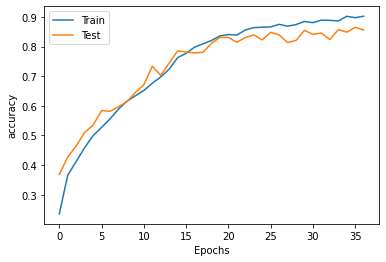

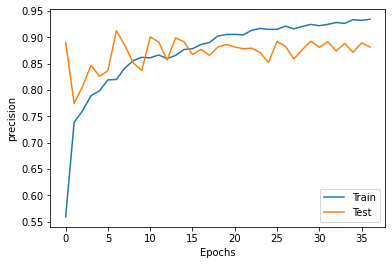

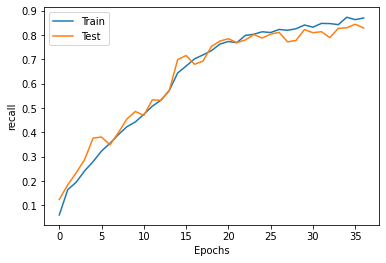

In [85]:
plot_metrics2(history3)

### Save Model

In [ ]:
# model3.save('../model_data_h5/final_model.h5', save_format='h5')

# Other Model Testing

## Model validation and Train set

In [8]:
# make validation set
validation_set = train[(train['site']=='S0009') | (train['site']=='S0043')| (train['site']=='S0059') |(train['site']== 'S0026')] # get validation set for 2 sites
# make training set
train_set = train[~train.isin(validation_set)].dropna() # remove the observations from train that are in the validation set

In [ ]:
train_set['animal_classification'].value_counts(normalize=True)

antelope_duiker     0.159523
civet_genet         0.149683
monkey_prosimian    0.147055
blank               0.143213
leopard             0.133172
rodent              0.119356
bird                0.094757
hog                 0.053242
Name: animal_classification, dtype: float64

In [ ]:
validation_set['animal_classification'].value_counts(normalize=True)

monkey_prosimian    0.187879
leopard             0.168485
rodent              0.146667
bird                0.142424
civet_genet         0.122424
hog                 0.113939
antelope_duiker     0.064848
blank               0.053333
Name: animal_classification, dtype: float64

In [10]:
train_path = 'data/train_features_img/'
test_path = 'data/test_features_img'

## Basic Model

 > Looking at all the different occurences of a specific animal
 
 > Look a the number of animals in each site

In [ ]:
train_path = 'data/train_features_img/'
test_path = 'data/test_features_img'

In [ ]:
from keras.utils.traceback_utils import include_frame
# ['antelope_duiker',	'bird',	'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian','rodent']
img_gen = ImageDataGenerator(
        brightness_range=[.4, 1.2],
        height_shift_range=.4,
        horizontal_flip=True
)
val_generator = img_gen.flow_from_dataframe(
    validation_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32
)
train_generator = img_gen.flow_from_dataframe(
    train_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32
)
channel_shift_range=150.0

Found 1650 validated image filenames belonging to 8 classes.
Found 14838 validated image filenames belonging to 8 classes.


In [ ]:
model = Sequential()
# layers
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
# output layer
model.add(Dense(units=8, activation='softmax'))

In [ ]:
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])

Epoch 1/50
  1/232 [..............................] - ETA: 1:24:55 - loss: 145.1792 - accuracy: 0.0625 - recall: 0.0625 - precision: 0.0625

In [ ]:
history = model.fit(
    train_generator,
    batch_size=64,
    epochs=50,
    validation_data=val_generator
)

Epoch 1/50
232/232 [==============================] - 103s 439ms/step - loss: 509.5956 - accuracy: 0.2724 - recall: 0.1659 - precision: 0.3901 - val_loss: 3.6223 - val_accuracy: 0.1564 - val_recall: 0.0109 - val_precision: 0.1463
Epoch 2/50
232/232 [==============================] - 101s 437ms/step - loss: 2.0401 - accuracy: 0.2955 - recall: 0.1466 - precision: 0.8346 - val_loss: 3.4349 - val_accuracy: 0.0733 - val_recall: 0.0067 - val_precision: 0.0667
Epoch 3/50
232/232 [==============================] - 100s 432ms/step - loss: 1.8466 - accuracy: 0.3483 - recall: 0.1917 - precision: 0.8676 - val_loss: 3.5950 - val_accuracy: 0.0970 - val_recall: 0.0230 - val_precision: 0.1674
Epoch 4/50
232/232 [==============================] - 102s 438ms/step - loss: 1.6729 - accuracy: 0.3886 - recall: 0.2430 - precision: 0.9008 - val_loss: 3.4567 - val_accuracy: 0.1430 - val_recall: 0.0642 - val_precision: 0.2630
Epoch 5/50
232/232 [==============================] - 102s 437ms/step - loss: 1.5489 -

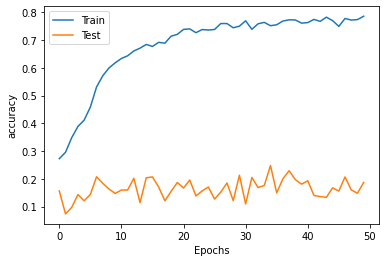

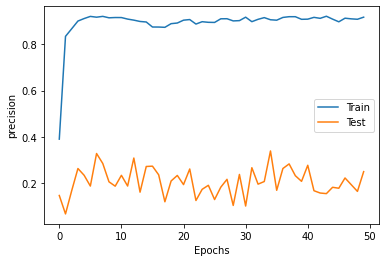

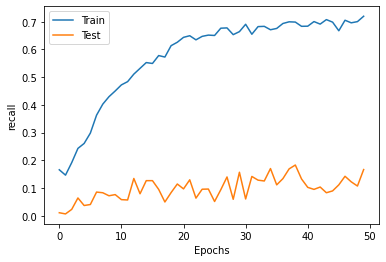

In [ ]:
plot_metrics(history)

## Additional Model Testing

### Model 1 Iterations - NA: Added EfficientNetB0 and Prelu layer

In [ ]:
from keras.utils.traceback_utils import include_frame
# image Gen stuff
# ['antelope_duiker',	'bird',	'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian','rodent']
img_gen = ImageDataGenerator(
        brightness_range=[.4, 1.2],
        height_shift_range=.4,
)
val_generator = img_gen.flow_from_dataframe(
    validation_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32
)
train_generator = img_gen.flow_from_dataframe(
    train_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32
)

In [3]:
model2 = Sequential()
# layers
model2.add(EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3)))
model2.add(PReLU(alpha_initializer=Constant(value=0.25)))
model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(0.6))
model2.add(Dense(units=32, activation='relu'))
model2.add(Dropout(0.3))
# output layer
model2.add(Dense(units=8, activation='softmax'))

model2.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
callback = [EarlyStopping(monitor='val_accuracy', patience=20)]
history2 = model2.fit(
    train_generator,
    batch_size=32,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)

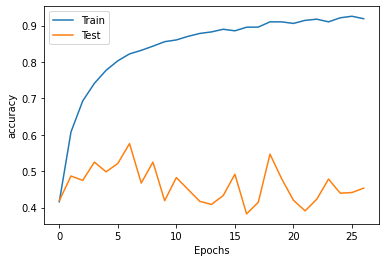

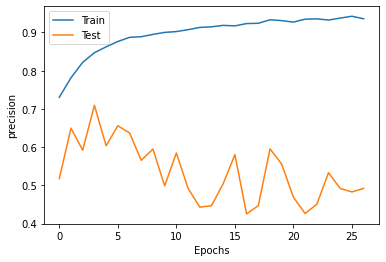

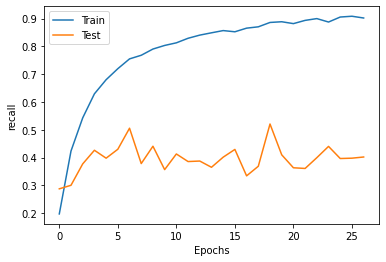

In [ ]:
plot_metrics(history2)

Model seems to be missing the mark in all metrics.

### Model 2 Iterations - NA: Added Aditional Dense and Dropout Layer longer  Patience on callback

In [ ]:
from keras.utils.traceback_utils import include_frame
# image Gen stuff
# ['antelope_duiker',	'bird',	'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian','rodent']
img_gen = ImageDataGenerator(
        brightness_range=[.4, 1.2],
        height_shift_range=.4,
        horizontal_flip=True,
)
val_generator = img_gen.flow_from_dataframe(
    validation_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32
)
train_generator = img_gen.flow_from_dataframe(
    train_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32
)

Found 1650 validated image filenames belonging to 8 classes.
Found 14838 validated image filenames belonging to 8 classes.


keras.preprocessing.image.DataFrameIterator

In [4]:
model3 = Sequential()
# input layers
model3.add(EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3)))
model3.add(PReLU(alpha_initializer=Constant(value=0.25)))
model3.add(GlobalAveragePooling2D())
model3.add(Flatten())
model3.add(Dropout(0.8))

# hidden layers
# 1
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.7))
# 2
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.6))
# 3
model3.add(Dense(units=32, activation='relu'))
model3.add(Dropout(0.5))
# 4 
# model3.add(Dense(units=64, activation='relu'))
# model3.add(Dropout(0.7))

# output layer
model3.add(Dense(units=8, activation='softmax'))

model3.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
callback = [EarlyStopping(monitor='val_loss', patience=20)]
history3 = model3.fit(
    train_generator,
    batch_size=32,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)

In [5]:
plot_metrics(history3)

Taï National Park also hosts an exceptional diversity of forest duikers including Jentink's duiker, banded or zebra duiker, Maxwell's duiker, Ogilby's duiker, black duiker, bay duiker, yellow-backed duiker and the royal antelope.

Forest rodents include the rusty-bellied brush-furred rat, the Edward's swamp rat and the woodland dormouse. Also recorded in the park is the Defua rat, which is characteristic of secondary forest.

In [ ]:
from keras.utils.traceback_utils import include_frame
# image Gen stuff
# ['antelope_duiker',	'bird',	'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian','rodent']
img_gen = ImageDataGenerator(
        height_shift_range=0.07,
        horizontal_flip=True,
        preprocessing_function=tensorflow.image.rgb_to_grayscale,
)
val_generator = img_gen.flow_from_dataframe(
    validation_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
)
train_generator = img_gen.flow_from_dataframe(
    train_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
)

Found 1650 validated image filenames belonging to 8 classes.
Found 14838 validated image filenames belonging to 8 classes.


In [ ]:
model3 = Sequential()
# input layers
model3.add(EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3)))
model3.add(PReLU(alpha_initializer=Constant(value=0.25)))
model3.add(GlobalAveragePooling2D())
model3.add(Flatten())
model3.add(Dropout(0.8))

# hidden layers
# 1
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.7))
# 2
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.6))
# 3
model3.add(Dense(units=32, activation='relu'))
model3.add(Dropout(0.5))
# 4 
# model3.add(Dense(units=32, activation='relu'))
# model3.add(Dropout(0.5))

# output layer
model3.add(Dense(units=8, activation='softmax'))

model3.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
callback = [EarlyStopping(monitor='val_loss', patience=10)]
history3 = model3.fit(
    train_generator,
    batch_size=32,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/100
464/464 [==============================] - 481s 1s/step - loss: 2.0622 - accuracy: 0.1925 - recall: 0.0181 - precision: 0.4991 - val_loss: 1.8987 - val_accuracy: 0.1673 - val_recall: 0.0964 - val_precision: 0.4251
Epoch 2/100
464/464 [==============================] - 469s 1s/step - loss: 1.8156 - accuracy: 0.2818 - recall: 0.0807 - precision: 0.7021 - val_loss: 1.7812 - val_accuracy: 0.2727 - val_recall: 0.0933 - val_precision: 0.4503
Epoch 3/100
464/464 [==============================] - 469s 1s/step - loss: 1.6804 - accuracy: 0.3426 - recall: 0.1304 - precision: 0.7425 - val_loss: 1.7252 - val_accuracy: 0.2848 - val_recall: 0.0867 - val_precision: 0.4751
Epoch 4/100
464/464 [==============================] - 468s 1s/step - loss: 1.6510 - accuracy: 0.3550 - recall: 0.1357 - precision: 0.7645 - val_loss: 1.7185 - val_accuracy: 0.3024 - val_recall: 0.0030 - val_precision: 0.1515
Epoch 5/100
464/464 [==============================] - 469s 1s/step - loss: 1.5456 - accuracy: 0

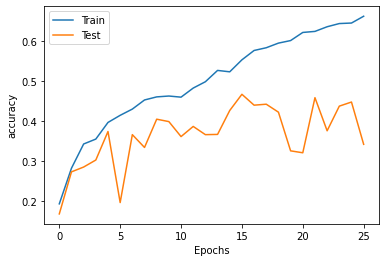

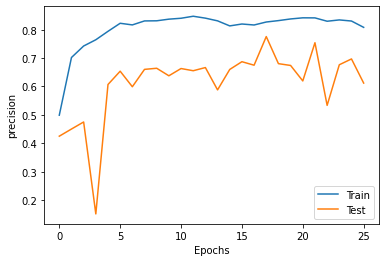

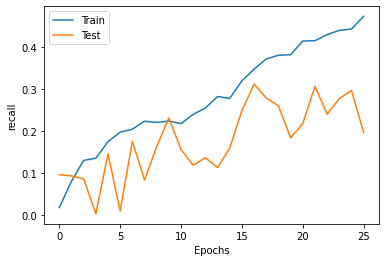

In [ ]:
plot_metrics(history3)

In [ ]:
from keras.utils.traceback_utils import include_frame
# image Gen stuff
# ['antelope_duiker',	'bird',	'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian','rodent']
img_gen_val = ImageDataGenerator()
val_generator = img_gen_val.flow_from_dataframe(
    validation_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
)
img_gen_train = ImageDataGenerator(
        height_shift_range=0.07,
        horizontal_flip=True,
        preprocessing_function=tensorflow.image.rgb_to_grayscale,
)
train_generator = img_gen_train.flow_from_dataframe(
    train_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
)

Found 1650 validated image filenames belonging to 8 classes.
Found 14838 validated image filenames belonging to 8 classes.


In [ ]:
model3 = Sequential()
# input layers
model3.add(EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3)))
model3.add(PReLU(alpha_initializer=Constant(value=0.25)))
model3.add(GlobalAveragePooling2D())

# model3.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
# # reduce the dimensionality inside the CNN
# model3.add(MaxPool2D(pool_size=(2,2)))
# before this information inside the NN is 3-d -- to connec to Dense
# layer, we need to squash it
model3.add(Flatten())

# hidden layers
# 1
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.7))
# 2
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.6))
# 3
model3.add(Dense(units=64, activation='relu'))
model3.add(Dropout(0.5))
# # 4 
model3.add(Dense(units=64, activation='relu'))
model3.add(Dropout(0.5))

# output layer
model3.add(Dense(units=8, activation='softmax'))

model3.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
callback = [EarlyStopping(monitor='val_accuracy', patience=5)]
history3 = model3.fit(
    train_generator,
    batch_size=32,
    epochs=50,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/50
464/464 [==============================] - 391s 825ms/step - loss: 1.9419 - accuracy: 0.2557 - recall: 0.0621 - precision: 0.7198 - val_loss: 1.9365 - val_accuracy: 0.1509 - val_recall: 0.0709 - val_precision: 0.9512
Epoch 2/50
464/464 [==============================] - 385s 829ms/step - loss: 1.6939 - accuracy: 0.3494 - recall: 0.1417 - precision: 0.7756 - val_loss: 1.7405 - val_accuracy: 0.3479 - val_recall: 0.0594 - val_precision: 0.5939
Epoch 3/50
464/464 [==============================] - 382s 823ms/step - loss: 1.5382 - accuracy: 0.3917 - recall: 0.1867 - precision: 0.8371 - val_loss: 1.5475 - val_accuracy: 0.3939 - val_recall: 0.1103 - val_precision: 0.9630
Epoch 4/50
464/464 [==============================] - 378s 814ms/step - loss: 1.4996 - accuracy: 0.4049 - recall: 0.1892 - precision: 0.8543 - val_loss: 1.5915 - val_accuracy: 0.4133 - val_recall: 0.0970 - val_precision: 0.8840
Epoch 5/50
464/464 [==============================] - 377s 813ms/step - loss: 1.4507 - a

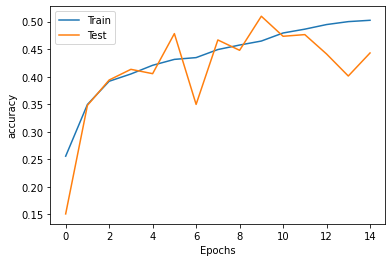

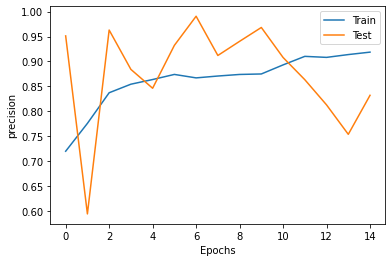

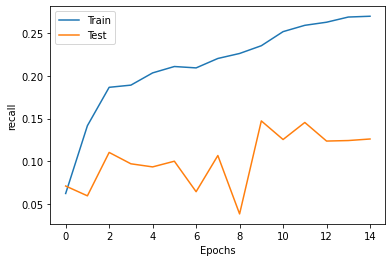

In [ ]:
plot_metrics(history3)

In [ ]:
from keras.utils.traceback_utils import include_frame
# image Gen stuff
# ['antelope_duiker',	'bird',	'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian','rodent']
img_gen_val = ImageDataGenerator()
val_generator = img_gen_val.flow_from_dataframe(
    validation_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
)
img_gen_train = ImageDataGenerator(
        height_shift_range=0.07,
        horizontal_flip=True,
        preprocessing_function=tensorflow.image.rgb_to_grayscale,
)
train_generator = img_gen_train.flow_from_dataframe(
    train_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
)

Found 1650 validated image filenames belonging to 8 classes.
Found 14838 validated image filenames belonging to 8 classes.


In [ ]:
from tensorflow.python.ops.gen_batch_ops import batch
from sklearn.model_selection import train_test_split
from keras import Input, Model
from sklearn.preprocessing import LabelEncoder


# train_site = train[['site','animal_classification']]
# X = pd.get_dummies(train_site[['site']])
# y = train_site['animal_classification']
# y = y.values.tolist()
# le = LabelEncoder()
# y = np.array(le.fit_transform(y))
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.15, stratify=y)



# # process image data using conv layers
input_num = Input(shape=(148,))
dense_1 = Dense(128, activation='relu')(input_num)
dropout_1 = Dropout(.7)(dense_1)
dense_2 = Dense(128, activation='relu')(dropout_1)
dropout_2 = Dropout(.7)(dense_2)
dense_3 = Dense(32, activation='relu')(dropout_2)
dropout_3 = Dropout(.6)(dense_3)
dense_4 = Dense(64, activation='relu')(dropout_3)
dropout_4 = Dropout(.5)(dense_4)
output = Dense(1, activation='sigmoid')(dropout_4) 


# # # # process numerical data
input_img = Input(shape=(256, 256, 3))

# model = Model(inputs=[input_num], outputs=[output])
# model.compile(loss=categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(learning_rate=.00001), metrics=['accuracy', 'Recall', 'Precision'])
# history = model.fit(
#     X_train,
#     y_train,
#     validation_data = (X_val, y_val),
#     epochs=80,
#     batch_size=32
# )


# nlp_input = Input(shape=(seq_length,)) 
# meta_input = Input(shape=(10,))

# emb = Embedding(output_dim=embedding_size, input_dim=100, input_length=seq_length)(nlp_input) 
# nlp_out = Bidirectional(LSTM(128))(emb) 
# concat = concatenate([nlp_out, meta_input]) 
# classifier = Dense(32, activation='relu')(concat) 
# output = Dense(1, activation='sigmoid')(classifier) 

# model = Model(inputs=[nlp_input , meta_input], outputs=[output])

# # merge the result with a merge layer such as concatenation
# merged = concatenate([out_conv, out_num])
# # the rest of the network ...

# out = Dense(num_classes, activation='softmax')(...)

# # create the model
# model = Model([inp_img, inp_num], out)



Become a little overfit but better in accuracy recall and precision. Needs quick change to Exsisting Dense layer or additional dense layer. Maybe more ImageGenerator augmentations. Val recall is low add more data complexity. To convergee Faster.

### Model 3 Iterations - NA: Added More dense layers and Dropout layers. Added additional hyperparms to Image Generator. color_mode=grayscale

In [ ]:
from keras.utils.traceback_utils import include_frame
# image Gen stuff
# ['antelope_duiker',	'bird',	'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian','rodent']
img_gen = ImageDataGenerator(
        brightness_range=[.4, 1.2],
        height_shift_range=.4,
        horizontal_flip=True,
)
val_generator = img_gen.flow_from_dataframe(
    validation_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    color_mode='grayscale', # increase accuracy and recall for train and test
    batch_size=32
)
train_generator = img_gen.flow_from_dataframe(
    train_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    color_mode='grayscale', # increase accuracy and recall for train and test
    batch_size=32
)

Found 1650 validated image filenames belonging to 8 classes.
Found 14838 validated image filenames belonging to 8 classes.


In [6]:
model3 = Sequential()
# input layers
model3.add(EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3)))
model3.add(PReLU(alpha_initializer=Constant(value=0.25)))
model3.add(GlobalAveragePooling2D())
model3.add(Flatten())
model3.add(Dropout(0.8))

# hidden layers
# 1
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.7))
# 2
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.6))
# 3
model3.add(Dense(units=32, activation='relu'))
model3.add(Dropout(0.5))
# 4 
model3.add(Dense(units=64, activation='relu')) # fix inconsistent loss on validation set
model3.add(Dropout(0.7))

# output layer
model3.add(Dense(units=8, activation='softmax'))
# opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

model3.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
callback = [EarlyStopping(monitor='val_loss', patience=20)]
history3 = model3.fit(
    train_generator,
    batch_size=32,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)

Val loss is consitently decreasing so fixxeed the corret number of dropoutlayer but now vall recall and val percision are low meaning the model is just rendomly guess. Mess with Image generator hyper parms.

In [ ]:
from keras.utils.traceback_utils import include_frame
# image Gen stuff
# ['antelope_duiker',	'bird',	'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian','rodent']
img_gen = ImageDataGenerator(
        height_shift_range=.4,
        horizontal_flip=True,
)
val_generator = img_gen.flow_from_dataframe(
    validation_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    color_mode='grayscale', # increase accuracy and recall for train and test
    batch_size=32
)
train_generator = img_gen.flow_from_dataframe(
    train_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    color_mode='grayscale', # increase accuracy and recall for train and test
    batch_size=32
)

In [ ]:
model3 = Sequential()
# input layers
model3.add(EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3)))
model3.add(PReLU(alpha_initializer=Constant(value=0.25)))
model3.add(GlobalAveragePooling2D())
model3.add(Flatten())
model3.add(Dropout(0.8))

# hidden layers
# 1
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.7))
# 2
model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(0.6))
# 3
model3.add(Dense(units=32, activation='relu'))
model3.add(Dropout(0.5))
# 4 
model3.add(Dense(units=64, activation='relu')) # fix inconsistent loss on validation set
model3.add(Dropout(0.7))

# output layer
model3.add(Dense(units=8, activation='softmax'))
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

model3.compile(loss=categorical_crossentropy, optimizer=opt, metrics=['accuracy', 'Recall', 'Precision'])
callback = [EarlyStopping(monitor='val_loss', patience=20)]
history3 = model3.fit(
    train_generator,
    batch_size=32,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)

The validation and val precision still missing the mark. Add a larger batch size

In [ ]:
from keras.utils.traceback_utils import include_frame
# image Gen stuff
# ['antelope_duiker',	'bird',	'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian','rodent']
img_gen = ImageDataGenerator(
        height_shift_range=.4,
        horizontal_flip=True,
)
val_generator = img_gen.flow_from_dataframe(
    validation_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    color_mode='grayscale', # increase accuracy and recall for train and test
    batch_size=32
)
train_generator = img_gen.flow_from_dataframe(
    train_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    color_mode='grayscale', # increase accuracy and recall for train and test
    batch_size=32
)

In [ ]:
model4 = Sequential()
# input layers
model4.add(EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3)))
model4.add(PReLU(alpha_initializer=Constant(value=0.25)))
model4.add(GlobalAveragePooling2D())
model4.add(Flatten())
model4.add(Dropout(0.8))

# hidden layers
# 1
model4.add(Dense(units=128, activation='relu'))
model4.add(Dropout(0.7))
# 2
model4.add(Dense(units=128, activation='relu'))
model4.add(Dropout(0.6))
# 3
model4.add(Dense(units=32, activation='relu'))
model4.add(Dropout(0.5))
# 4 
model4.add(Dense(units=32, activation='relu')) # fix inconsistent loss on validation set
model4.add(Dropout(0.5))

# output layer
model4.add(Dense(units=8, activation='softmax'))
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

model4.compile(loss=categorical_crossentropy, optimizer=opt, metrics=['accuracy', 'Recall', 'Precision'])
callback = [EarlyStopping(monitor='val_loss', patience=20)]
history3 = model4.fit(
    train_generator,
    batch_size=32,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)

### Model 4 - NA

In [12]:
from keras.utils.traceback_utils import include_frame
# image Gen stuff
# ['antelope_duiker',	'bird',	'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian','rodent']
img_gen_val = ImageDataGenerator()
val_generator = img_gen_val.flow_from_dataframe(
    validation_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
)
img_gen_train = ImageDataGenerator(
        height_shift_range=0.07,
        horizontal_flip=True,
        preprocessing_function=tensorflow.image.rgb_to_grayscale,
)
train_generator = img_gen_train.flow_from_dataframe(
    train_set, 
    directory=train_path, 
    x_col='filename', 
    y_col='animal_classification', 
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
)

Found 1650 validated image filenames belonging to 8 classes.
Found 14838 validated image filenames belonging to 8 classes.


In [19]:
effnet = EfficientNetB0(include_top=False, weights='imagenet')
effnet.trainable = False
model_es = Sequential()
model_es.add(effnet)
model_es.add(GlobalAveragePooling2D())
model_es.add(Flatten())
model_es.add(Dense(units=128, activation='relu'))
model_es.add(Dropout(0.7))
model_es.add(Dense(units=128, activation='relu'))
model_es.add(Dropout(0.6))
model_es.add(Dense(8, activation='softmax'))
model_es.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
callback = [EarlyStopping(monitor='val_loss', patience=20)]
history3 = model_es.fit(
    train_generator,
    batch_size=32,
    epochs=100,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/100
464/464 [==============================] - 287s 607ms/step - loss: 1.7715 - accuracy: 0.3155 - recall: 0.1093 - precision: 0.7013 - val_loss: 1.5801 - val_accuracy: 0.3848 - val_recall: 0.1370 - val_precision: 0.5870
Epoch 2/100
464/464 [==============================] - 279s 601ms/step - loss: 1.5346 - accuracy: 0.4072 - recall: 0.1940 - precision: 0.7538 - val_loss: 1.4987 - val_accuracy: 0.4218 - val_recall: 0.1782 - val_precision: 0.5600
Epoch 3/100
464/464 [==============================] - 280s 603ms/step - loss: 1.4494 - accuracy: 0.4363 - recall: 0.2336 - precision: 0.7737 - val_loss: 1.6049 - val_accuracy: 0.3842 - val_recall: 0.1170 - val_precision: 0.5796
Epoch 4/100
464/464 [==============================] - 284s 611ms/step - loss: 1.3944 - accuracy: 0.4579 - recall: 0.2560 - precision: 0.7815 - val_loss: 1.6051 - val_accuracy: 0.3927 - val_recall: 0.1388 - val_precision: 0.6123
Epoch 5/100
464/464 [==============================] - 283s 610ms/step - loss: 1.341

## Beta For later Improvements


In [72]:
# from sklearn.model_selection import train_test_split, GroupShuffleSplit
# X = train[['id', 'filename', 'animal_classification']]
# y = train['animal_classification']

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)
